In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-notebook')

%matplotlib inline

In [2]:
orig_data = pd.read_csv('../data/kc_house_data.csv', index_col=0)
df = orig_data.copy()

In [3]:
#remove extra columns
df = df.drop(df[['date', 'view', 'sqft_lot', 'sqft_above', 'nuisance','greenbelt','floors','sqft_garage','sqft_patio', 'sqft_basement', 'lat', 'long' ]], axis = 1)
# df = df['heat_source'].notna()
# df.isnull().sum()

In [4]:
df['Age'] = 2022- df['yr_built'].astype(int)
grade_num = []
for index, row in df.iterrows():
    grade_num.append(int((str(row['grade'])[0:2])))
df['grade_num'] = grade_num
df.drop('grade', axis = 1)
df['heat_num'] = df['heat_source'].replace({'Gas': 1, 'Electricity' : 2, 'Oil': 3, 'Gas/Solar': 4, 'Electricity/Solar':5, 'Oil/Solar':6, 'Other':7 })
df['condition_num'] = df['condition'].replace({'Poor': 1, 'Fair' : 2, 'Average': 3, 'Good': 4, 'Very Good':5 })
df.drop('condition', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,heat_source,sewer_system,yr_built,yr_renovated,address,Age,grade_num,heat_num,condition_num
id,,,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,NO,Good,7 Average,Gas,PUBLIC,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",53,7,1.0,4
8910500230,920000.0,5,2.5,2770,NO,Average,7 Average,Oil,PUBLIC,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",72,7,3.0,3
1180000275,311000.0,6,2.0,2880,NO,Average,7 Average,Gas,PUBLIC,1956,0,"8504 South 113th Street, Seattle, Washington 9...",66,7,1.0,3
1604601802,775000.0,3,3.0,2160,NO,Average,9 Better,Gas,PUBLIC,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",12,9,1.0,3
8562780790,592500.0,2,2.0,1120,NO,Average,7 Average,Electricity,PUBLIC,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",10,7,2.0,3


In [5]:
#Added column to show whether or not house was renovated, and if so how long ago
# df['Renovation(y/n)'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
# df['Renovation_Age'] = df['yr_renovated'].apply(lambda x: 2022-x if x > 0 else 0)



In [6]:
historic = df[df['yr_built'] < 1972]  
historic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13498 entries, 7399300360 to 9557800100
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          13498 non-null  float64
 1   bedrooms       13498 non-null  int64  
 2   bathrooms      13498 non-null  float64
 3   sqft_living    13498 non-null  int64  
 4   waterfront     13498 non-null  object 
 5   condition      13498 non-null  object 
 6   grade          13498 non-null  object 
 7   heat_source    13476 non-null  object 
 8   sewer_system   13496 non-null  object 
 9   yr_built       13498 non-null  int64  
 10  yr_renovated   13498 non-null  int64  
 11  address        13498 non-null  object 
 12  Age            13498 non-null  int32  
 13  grade_num      13498 non-null  int64  
 14  heat_num       13476 non-null  float64
 15  condition_num  13498 non-null  int64  
dtypes: float64(3), int32(1), int64(6), object(6)
memory usage: 1.7+ MB


# BUILDING CONDITION

	Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

# BUILDING GRADE

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [7]:
df.corr()['price']

price            1.000000
bedrooms         0.289204
bathrooms        0.480401
sqft_living      0.608521
yr_built         0.096013
yr_renovated     0.084786
Age             -0.096013
grade_num        0.565263
heat_num        -0.117652
condition_num   -0.008704
Name: price, dtype: float64

In [8]:
historic_corr = historic.corr()['price'].map(abs).sort_values(ascending=False)

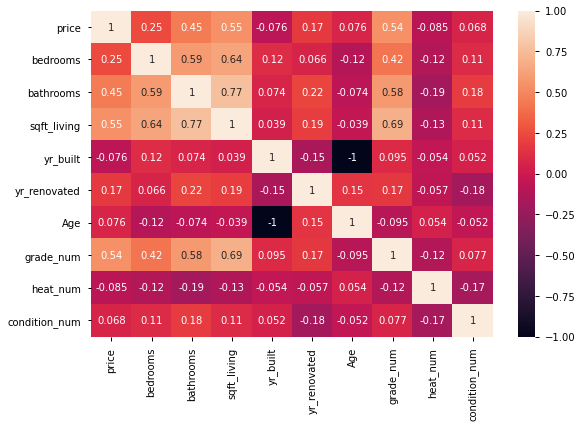

In [9]:
sns.heatmap(historic.corr(),annot=True)
fig=plt.gcf()
fig.set_size_inches(9,6)
plt.show()

In [10]:
X = df['grade_num']
y = df['price']

dummy_regr = DummyRegressor(strategy="mean")
print(dummy_regr.fit(X, y))

print(dummy_regr.predict(X))
print(dummy_regr.score(X, y))

DummyRegressor()
[1108535.837871 1108535.837871 1108535.837871 ... 1108535.837871
 1108535.837871 1108535.837871]
0.0


In [12]:
ohe = OneHotEncoder()
historic_1 = historic[['price', 'Age', 'grade_num', 'condition_num']]
ohe.fit(historic_1)

OneHotEncoder()

In [13]:
historic1_encoded = ohe.transform(historic_1)
historic1_encoded

<13498x2893 sparse matrix of type '<class 'numpy.float64'>'
	with 53992 stored elements in Compressed Sparse Row format>